# Digital acceptance testing

Goal is to make it easy to modify f-eng configuration while recording data.

1. Write MS file
- set all inputs to zeros
- set pol a inputs to adc, then pol b to adc
- set eq coeffs to zero for first ten channels on first snap, then iterate through all snaps

2. Write beamformed data
- set inputs to zeros
- set pol a inputs to adc, then pol b to adc
- set eq coeffs to zero for first ten channels on first snap, then iterate through all snaps
3. Read autos from MS file
- confirm order of zeros, adc on pol on sequence, channel off sequence, and antennas off sequence
4. Read beamformed data
- confirm order of zeros, adc on pol order, channel off order by channel

### Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

from lwa_f import snap2_fengine, snap2_feng_etcd_client
from lwa_antpos import mapping
import casacore.tables

Read antpos from etcd


In [2]:
from bokeh.layouts import column, row
from bokeh.models import ColumnDataSource, DataRange1d, Select
from bokeh.palettes import Viridis
from bokeh.plotting import figure
from bokeh.io import show, output_notebook

output_notebook()

Loading BokehJS ...

In [83]:
snap2names = [f'snap{i:02}' for i in range(1, 12)]

def set_input(mode='use_zero', stream=None, pol=None, names=snap2names):
    """ Set the input block method
    mode can be "use_zero", "use_adc", "use_noise", "zero_coeffs",
    "reset_coeffs", "get_status".
    """

    if isinstance(names, str):
        names = [names]

    for name in names:
        f = snap2_fengine.Snap2Fengine(name)
        num = int(name.lstrip('snap'))

        if (pol is None) or isinstance(stream, int):
            print(f"Set stream: {stream}")
            run(f, stream, mode=mode)
        elif (stream is None) and (pol is not None):
            antpols = []
            if pol == 'a':
                inps = list(range(0,64,2))
            elif pol == 'b':
                inps = list(range(1,64,2))
            for inp in inps:
                antpols.append(mapping.snap2_to_antpol(num, inp))
                run(f, inp, mode=mode)
            print(f"Set antpols {antpols}")

def run(f, stream, mode='use_zero', zerochans=range(0, 5)):
    if mode == 'use_zero':
        f.input.use_zero(stream)
    elif mode == 'use_adc':
        f.input.use_adc(stream)
    elif mode == 'use_noise':
        f.input.use_noise(stream)
    elif mode == 'get_status':
        print('input status:')
        f.input.get_status()
        print('eqtvg status:')
        f.eqtvg.get_status()
    elif mode == 'reset_coeffs':
        f.eq.initialize(read_only=False)
    elif mode == 'zero_coeffs':
        for i in range(64):
            coeffs, scalefactor = f.eq.get_coeffs(i)
            # [1] is scale factor (coeff binary point), coeff = 9600/2**scalefactor?
            coeffs2 = coeffs >> zeropoint
            coeffs2[:5] = 0
            f.eq.set_coeffs(i, coeffs=coeffs2)
    else:
        print(f'mode {mode} not recognized')
# or
#        f.eqtvg.tvg_enable()
#        f.eqtvg.write_stream_tvg()
#        f.eqtvg.write_const_per_stream()
#        f.eqtvg.write_freq_ramp()

def plot_autospecs(names=snap2names, ret=False, bokeh=True):
    """ plots auto correlations for sets of snap2names.
    Can optionally return array with ret=True.
    """

    if isinstance(names, str):
        names = [names]

    autospecs = []
    for name in names:
        f = snap2_fengine.Snap2Fengine(name)
        for i in range(64):
            spec = f.corr.get_new_corr(i, i).real  # 8-channel average, normalized by accumulated time/chans
            autospecs.append(spec)
    autospecs = np.vstack(autospecs)

    if bokeh:
        TOOLTIPS = [("x", "$x"), ("y", "$y"), ("value", "@image")]
        plot = figure(plot_width=800, plot_height=400, tooltips=TOOLTIPS)
        _ = plot.image(image=[autospecs], x=0, y=0, dw=512, dh=len(autospecs), palette=Viridis[4])
        plot.xaxis.axis_label = 'Channel (8-chan avg)'
        plot.yaxis.axis_label = 'Input (64 per snap, stacked)'
        show(plot)
    else:
        fig, (ax0) = plt.subplots(1, 1, figsize=(12,12))
        ax0.imshow(autospecs, origin='lower', interpolation='nearest')

    if ret:
        return autospecs

In [24]:
# optionally run cold start

cold_start = False
program = False

if cold_start or program:
    for snap2name in snap2names:
        f = snap2_fengine.Snap2Fengine(snap2name)
        if program:
            f.program()
        print(snap2name, f.fpga.is_programmed())
        f.cold_start_from_config('/home/ubuntu/proj/lwa-shell/caltech-lwa/control_sw/config/lwa_corr_config.yaml') 

### Visualize initial state

In [87]:
set_input(mode='use_adc')

2022-03-10 19:36:13,664 - lwa_f.blocks.block:snap01 - WARNING -  - hostname (10.40.0.157) couldn't be turned into integer serial
2022-03-10 19:36:13,906 - lwa_f.blocks.block:snap01 - INFO - adc - Detected FMC ADC board on port 0
2022-03-10 19:36:14,197 - lwa_f.blocks.block:snap01 - INFO - adc - Detected FMC ADC board on port 1
Set stream: None
2022-03-10 19:36:14,720 - lwa_f.blocks.block:snap02 - WARNING -  - hostname (10.40.0.132) couldn't be turned into integer serial
2022-03-10 19:36:14,988 - lwa_f.blocks.block:snap02 - INFO - adc - Detected FMC ADC board on port 0
2022-03-10 19:36:15,292 - lwa_f.blocks.block:snap02 - INFO - adc - Detected FMC ADC board on port 1
Set stream: None
2022-03-10 19:36:15,816 - lwa_f.blocks.block:snap03 - WARNING -  - hostname (10.40.0.136) couldn't be turned into integer serial
2022-03-10 19:36:16,061 - lwa_f.blocks.block:snap03 - INFO - adc - Detected FMC ADC board on port 0
2022-03-10 19:36:16,289 - lwa_f.blocks.block:snap03 - INFO - adc - Detected FMC

In [88]:
autospecs = plot_autospecs(ret=True)

2022-03-10 19:36:24,888 - lwa_f.blocks.block:snap01 - WARNING -  - hostname (10.40.0.157) couldn't be turned into integer serial
2022-03-10 19:36:25,186 - lwa_f.blocks.block:snap01 - INFO - adc - Detected FMC ADC board on port 0
2022-03-10 19:36:25,487 - lwa_f.blocks.block:snap01 - INFO - adc - Detected FMC ADC board on port 1
2022-03-10 19:36:39,837 - lwa_f.blocks.block:snap02 - WARNING -  - hostname (10.40.0.132) couldn't be turned into integer serial
2022-03-10 19:36:40,138 - lwa_f.blocks.block:snap02 - INFO - adc - Detected FMC ADC board on port 0
2022-03-10 19:36:40,450 - lwa_f.blocks.block:snap02 - INFO - adc - Detected FMC ADC board on port 1
2022-03-10 19:36:54,341 - lwa_f.blocks.block:snap03 - WARNING -  - hostname (10.40.0.136) couldn't be turned into integer serial
2022-03-10 19:36:54,568 - lwa_f.blocks.block:snap03 - INFO - adc - Detected FMC ADC board on port 0
2022-03-10 19:36:54,866 - lwa_f.blocks.block:snap03 - INFO - adc - Detected FMC ADC board on port 1
2022-03-10 19

### Observing sequence


In [ ]:
#tblock = 3*10  # seconds

#set_input(mode='use_zeros')
#time.sleep(tblock)
#set_input(mode='use_adc', pol='a')
#time.sleep(tblock)
#set_input(mode='use_adc', pol='b')
#time.sleep(tblock)
#for name in snap2names:
#    set_input(mode='zero_coeffs', name=name) # zeros some channels
#    time.sleep(tblock)
#set_input(mode='reset_coeffs')
#time.sleep(tblock)
#set_input(mode='use_zeros')
#time.sleep(tblock)

### Inspect visibility data (need to copy it or run from lxdlwagpu09)

In [89]:
tb = casacore.tables.table('/home/ubuntu/data/slow/20220310_020859_84MHz.ms')

Successful readonly open of default-locked table /home/ubuntu/data/slow/20220310_020859_84MHz.ms: 22 columns, 62128 rows


In [94]:
tb2 = tb.query('ANTENNA1=ANTENNA2')
data = tb2.getcol("DATA").real
times = tb2.getcol("TIME")
print(data.shape, times.shape)


(352, 192, 4) (352,)


Text(0, 0.5, 'channel')

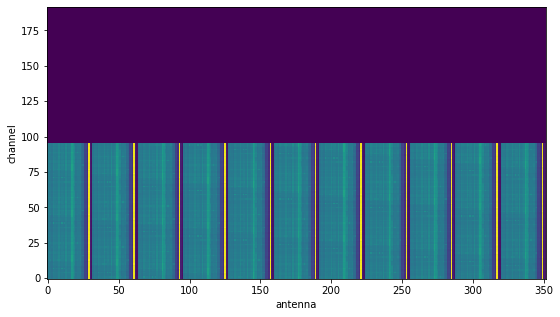

In [101]:
fig, ax = plt.subplots(1, 1, figsize=(12,5))
ax.imshow(data[..., 0].transpose(), origin='lower', interpolation='nearest')
ax.set_xlabel('antenna')
ax.set_ylabel('channel')